In [ ]:
# import getpass
# import os

# password = getpass.getpass()
# command = "sudo -S bash trust_apple_corp_root_cas.sh"
# os.system('echo %s | %s' % (password, command))
# os.system('echo %s' % (command))

# %conda install -c conda-forge nodejs
# %conda install -n base -c conda-forge jupyterlab_widgets
# %conda env list

# %pip install --upgrade geopandas
# %pip install --upgrade matplotlib
# %pip install --upgrade palettable
# %pip install --upgrade sidecar
# %pip install --upgrade lonboard
# %pip install --upgrade pyogrio
# %pip install --upgrade scikit-learn

In [6]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from palettable.colorbrewer.diverging import BrBG_10
from sidecar import Sidecar

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
# %matplotlib inline

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Global variable to store the currently displayed Sidecar widget
current_sidecar = None

In [7]:
csv_file = "1900-2018-GH.csv"

gdf = gpd.read_file(
    csv_file,
    engine="pyogrio",
    use_arrow=True,
    X_POSSIBLE_NAMES="longitude",
    Y_POSSIBLE_NAMES="latitude",
    KEEP_GEOM_COLUMNS="NO",
)

## Quick look at the data

In [8]:
gdf

,time,depth,mag,id,place,geohash,geometry
0,2018-07-05T15:17:36.947Z,8.6,4.5,nn00642964,"15 km WNW of Sandy Valley, Nevada",9qmsj,POINT (-115.77580 35.89450)
1,2016-06-10T08:04:38.700Z,12.31,5.19,ci37374687,"20km NNW of Borrego Springs, CA",9mvnn,POINT (-116.44267 33.43150)
2,2014-07-05T16:59:34.090Z,7.25,4.58,ci15520985,"11km NE of Running Springs, CA",9qhg0,POINT (-117.02667 34.28233)
3,2014-03-29T04:09:42.170Z,5.09,5.1,ci15481673,"2km NW of Brea, CA",9qh1h,POINT (-117.91583 33.93250)
4,2013-03-11T16:56:06.060Z,10.943,4.7,ci15296281,"21km ESE of Anza, CA",9mvnt,POINT (-116.45817 33.50083)
...,...,...,...,...,...,...,...
329,1910-05-13T06:20:00.000Z,,5.0,ushis504,"7 km WNW of Lake Elsinore, California",9mux8,POINT (-117.40000 33.70000)
330,1910-04-11T07:57:00.000Z,,5.0,ushis501,"7 km WNW of Lake Elsinore, California",9mux8,POINT (-117.40000 33.70000)
331,1908-11-04T08:37:00.000Z,,6.5,ushis478,"44 km NE of Searles Valley, California",9qkuc,POINT (-117.00000 36.00000)
332,1907-09-20T01:54:00.000Z,,5.3,ushis468,"1 km SE of Running Springs, California",9qhdx,POINT (-117.10000 34.20000)


In [9]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   time      334 non-null    object  
 1   depth     334 non-null    object  
 2   mag       334 non-null    object  
 3   id        334 non-null    object  
 4   place     334 non-null    object  
 5   geohash   334 non-null    object  
 6   geometry  334 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 18.4+ KB


## Check for numeric None, NaN, or NaT values

In [10]:
def check_numeric_nulls():
    numeric_null_mask = gdf.applymap(lambda x: pd.isna(x))

    # Count the number of numeric null values in each column
    return numeric_null_mask.sum()

check_numeric_nulls()

time        0
depth       0
mag         0
id          0
place       0
geohash     0
geometry    0
dtype: int64

In [11]:
# Check for 'None' string cells in the DataFrame
def check_none_string():
    none_string_mask = gdf.applymap(lambda x: x == 'None')

    # Count the number of 'None' string cells in each column
    return none_string_mask.sum()

check_none_string()

time        0
depth       0
mag         0
id          0
place       0
geohash     0
geometry    0
dtype: int64

In [12]:
# Check for empty cells in the DataFrame
def check_empty_cells():
    empty_cells_mask = gdf.applymap(lambda x: x == '')

    # Count the number of empty cells in each column
    return empty_cells_mask.sum()

check_empty_cells()

time         0
depth       21
mag          0
id           0
place        0
geohash      0
geometry     0
dtype: int64

## Convert required columns to numeric and replace NaN values with the median

In [13]:
# Convert these columns to numeric, coercing errors to NaN
gdf['depth'] = pd.to_numeric(gdf['depth'], errors='coerce')
gdf['mag'] = pd.to_numeric(gdf['mag'], errors='coerce')
# Convert datetime strings to timestamps
# gdf['time'] = pd.to_datetime(gdf['time']).astype(int) / 10**9

# Calculate the median of the 'depth' column
depth_median = gdf['depth'].median()

# Calculate the median of the 'mag' column
depth_median = gdf['mag'].median()

# Fill NaN values with the median
gdf['depth'] = gdf['depth'].fillna(depth_median)
gdf['mag'] = gdf['mag'].fillna(depth_median)

In [14]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   time      334 non-null    object  
 1   depth     334 non-null    float64 
 2   mag       334 non-null    float64 
 3   id        334 non-null    object  
 4   place     334 non-null    object  
 5   geohash   334 non-null    object  
 6   geometry  334 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 18.4+ KB


In [15]:
check_empty_cells()

time        0
depth       0
mag         0
id          0
place       0
geohash     0
geometry    0
dtype: int64

In [16]:
gdf

,time,depth,mag,id,place,geohash,geometry
0,2018-07-05T15:17:36.947Z,8.600,4.50,nn00642964,"15 km WNW of Sandy Valley, Nevada",9qmsj,POINT (-115.77580 35.89450)
1,2016-06-10T08:04:38.700Z,12.310,5.19,ci37374687,"20km NNW of Borrego Springs, CA",9mvnn,POINT (-116.44267 33.43150)
2,2014-07-05T16:59:34.090Z,7.250,4.58,ci15520985,"11km NE of Running Springs, CA",9qhg0,POINT (-117.02667 34.28233)
3,2014-03-29T04:09:42.170Z,5.090,5.10,ci15481673,"2km NW of Brea, CA",9qh1h,POINT (-117.91583 33.93250)
4,2013-03-11T16:56:06.060Z,10.943,4.70,ci15296281,"21km ESE of Anza, CA",9mvnt,POINT (-116.45817 33.50083)
...,...,...,...,...,...,...,...
329,1910-05-13T06:20:00.000Z,4.800,5.00,ushis504,"7 km WNW of Lake Elsinore, California",9mux8,POINT (-117.40000 33.70000)
330,1910-04-11T07:57:00.000Z,4.800,5.00,ushis501,"7 km WNW of Lake Elsinore, California",9mux8,POINT (-117.40000 33.70000)
331,1908-11-04T08:37:00.000Z,4.800,6.50,ushis478,"44 km NE of Searles Valley, California",9qkuc,POINT (-117.00000 36.00000)
332,1907-09-20T01:54:00.000Z,4.800,5.30,ushis468,"1 km SE of Running Springs, California",9qhdx,POINT (-117.10000 34.20000)


In [17]:
gdf.describe()

,depth,mag
count,334.000000,334.000000
mean,6.151335,4.938862
std,4.344186,0.459936
min,-1.934000,4.500000
25%,4.021750,4.612500
50%,6.000000,4.800000
75%,7.241000,5.100000
max,19.720000,7.300000


<Axes: >

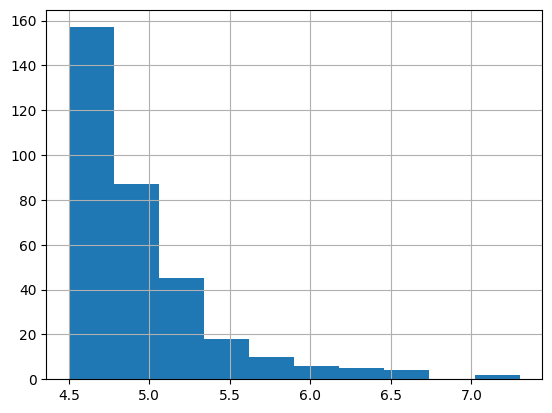

In [18]:
gdf['mag'].hist()

In [19]:
layer = ScatterplotLayer.from_geopandas(gdf)
map_ = Map(layers=[layer], _height=1800)

# from shapely.geometry import MultiPoint

# #Calculate centroids
# centroids = gdf.centroid

# #Extract centroid coordinates into a MultiPoint object
# multi_point = MultiPoint([geom.xy for geom in centroids])

# # Calculate the median centroid
# median_centroid = multi_point.centroid

# print(f"{median_centroid.coords.xy[0][0]}, {median_centroid.coords.xy[1][0]}")

# map_._initial_view_state={
#     "longitude": median_centroid.coords.xy[0][0], 
#     "latitude": median_centroid.coords.xy[1][0], 
#     "zoom": 7}

# ---------------------------------------------------------------------
# Calculate the centroid for each geometry and collect them
centroids = gdf.geometry.apply(lambda geom: (geom.centroid.x, geom.centroid.y)).tolist()

# Calculate the median centroid
median_centroid = (
    sorted(centroids, key=lambda x: x[0])[len(centroids) // 2][0],  # Median x-coordinate
    sorted(centroids, key=lambda x: x[1])[len(centroids) // 2][1]   # Median y-coordinate
)

# Reverse the order of coordinates to match (latitude, longitude)
# median_centroid = median_centroid[::-1]
# median_centroid

map_._initial_view_state={"longitude": median_centroid[0], "latitude": median_centroid[1], "zoom": 7.5}

In [20]:
# Function to create and display a Sidecar widget
def display_sidecar():
    global current_sidecar
    if current_sidecar is not None:
        current_sidecar.close()  # Close the currently displayed Sidecar widget
    current_sidecar = Sidecar(title='CA Map')
    with current_sidecar:
        display(map_)  # Replace this with your desired content

# Test the function
display_sidecar()

# with Sidecar(title="CA Map") as sc:
#     display(map_)

In [21]:
colname = "mag"
gdf[colname] = pd.to_numeric(gdf[colname])

### Linear normalization process to convert magnitude values ranging from 0 to 9 to a range of 0 to 1 to colormap the data

In [22]:
normalizer = mpl.colors.Normalize(0, 9)
normalized_values = normalizer(gdf[colname])

In [23]:
normalized_values

masked_array(data=[0.5       , 0.57666667, 0.50888889, 0.56666667,
                   0.52222222, 0.60222222, 0.51111111, 0.51777778,
                   0.57666667, 0.53888889, 0.52666667, 0.55555556,
                   0.52555556, 0.53      , 0.56222222, 0.60444444,
                   0.52555556, 0.56444444, 0.5       , 0.50777778,
                   0.51444444, 0.54222222, 0.57777778, 0.51555556,
                   0.51222222, 0.5       , 0.55444444, 0.53      ,
                   0.53111111, 0.55777778, 0.54777778, 0.57444444,
                   0.51777778, 0.50111111, 0.51444444, 0.55444444,
                   0.50111111, 0.55333333, 0.51      , 0.50333333,
                   0.50333333, 0.51555556, 0.50888889, 0.59666667,
                   0.51444444, 0.5       , 0.52888889, 0.52666667,
                   0.62222222, 0.64111111, 0.55333333, 0.53      ,
                   0.52222222, 0.78888889, 0.54777778, 0.53333333,
                   0.53555556, 0.51444444, 0.53111111, 0.53333

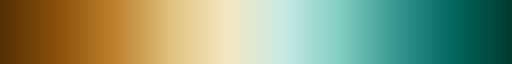

In [24]:
BrBG_10.mpl_colormap

In [25]:
layer.radius_min_pixels = 0.5
layer.get_fill_color = apply_continuous_cmap(normalized_values, BrBG_10)

In [26]:
log_normalizer = mpl.colors.LogNorm(3, 9, clip=True)
log_values = log_normalizer(gdf[colname])

In [27]:
layer.get_fill_color = apply_continuous_cmap(log_values, BrBG_10)
layer.get_radius = log_values * 2500
layer.radius_units = "meters"

In [34]:
# Extract x and y coordinates from the geometry column
gdf['longitude'] = gdf.geometry.x
gdf['latitude'] = gdf.geometry.y
# gdf

<Axes: xlabel='longitude', ylabel='latitude'>

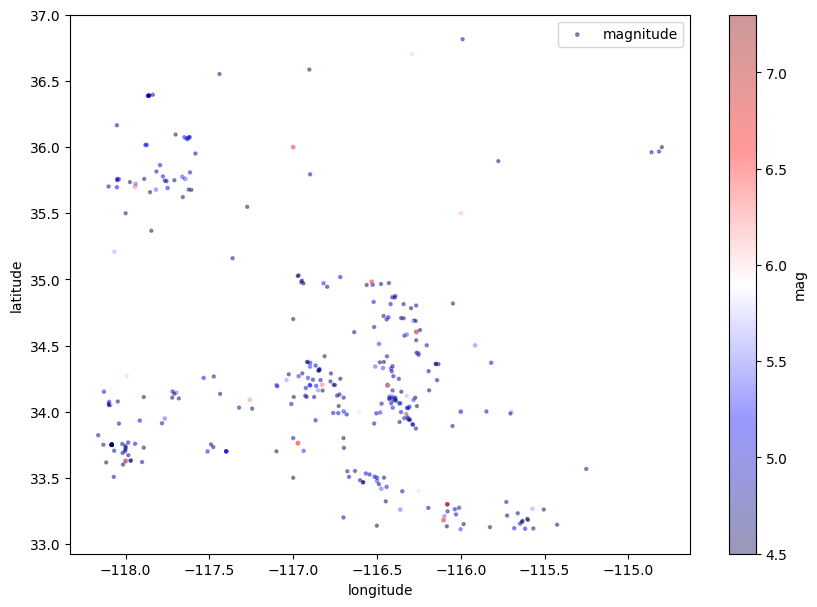

In [29]:
gdf.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=gdf["mag"], label="magnitude", figsize=(10,7), c="mag", cmap=plt.get_cmap("seismic"), colorbar=True,
    sharex=False)

In [30]:
from sklearn.model_selection import train_test_split

columns_to_drop = ['time', 'mag', 'id', 'place', 'geohash', 'geometry']
X = gdf.drop(columns_to_drop, axis=1)
y = gdf['mag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)
# model.fit(gdf[["time", "depth", "longitude", "latitude"]], gdf["mag"])

# Make predictions
y_pred = model.predict(X_test)

y_pred

array([4.8839147 , 4.802337  , 4.89927885, 4.94453629, 4.88283883,
       4.79967337, 4.80041747, 4.95800088, 4.93961024, 4.90034947,
       4.9188429 , 4.94450374, 4.87393239, 4.95984415, 4.87966986,
       4.89286654, 4.9205961 , 4.78517154, 4.92797043, 4.91903419,
       5.14658846, 4.98904667, 4.88101561, 4.91993067, 4.9573141 ,
       4.91848596, 5.16949987, 5.05357535, 4.93384346, 4.92115816,
       4.97863743, 4.74517266, 4.95388661, 4.9513752 , 4.92658841,
       4.89597185, 4.92613158, 4.98069   , 4.91564076, 4.97003118,
       4.97151255, 4.91094674, 4.95894295, 4.95695323, 4.94383601,
       4.92440495, 4.92334574, 4.92303194, 4.89636247, 4.90782672,
       4.84888745, 4.99324457, 4.94173928, 4.90311457, 4.98114038,
       4.91545852, 4.92992425, 5.1399959 , 4.85900905, 4.87335213,
       4.80993969, 4.95813358, 4.94739132, 4.81695646, 4.87951728,
       4.80024022, 4.92928696])

In [32]:
coef = model.coef_
coef

array([0.00942343, 0.07287432, 0.06362785])

In [33]:
intercept = model.intercept_
intercept

11.202975059026272